In [6]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.ticker import NullFormatter
plt.rcParams['font.size'] = 13

# manifold.TSNE
from sklearn import manifold  #, datasets
from time import time

from sklearn.neighbors import NearestNeighbors

## Data and labels 
In this example we know the labels, hence we can test the performances of t-SNE and DBSCAN

In [7]:
fname,fnamey="x_12d.dat","y_12d.dat"
data=np.loadtxt("DATA/"+fname, delimiter='\t')
y=np.loadtxt("DATA/"+fnamey,dtype=int)
N=len(data)
D=len(data[0])
print("N=",N,"  L=D=",D)

x=data

N= 600   L=D= 12


## Find the typical minimum distance between points
This yields a typical scale, to be used as a reference for "eps"

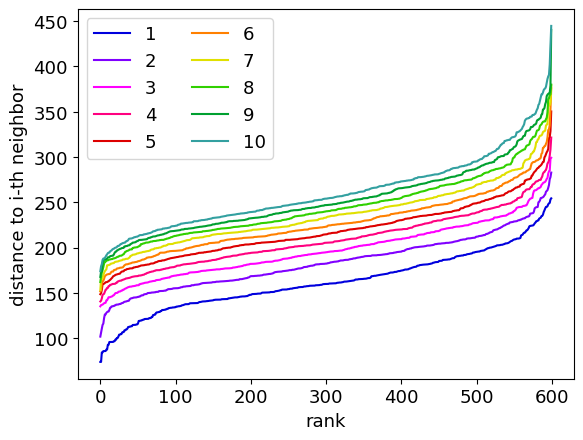

mean minimum distance between points:  162.34622464324366


In [8]:
nn = 10
nbrs = NearestNeighbors(n_neighbors=nn+1).fit(x) #, algorithm='ball_tree'
d, ind = nbrs.kneighbors(x)
dd=d.T
# note: dd[0] has a trivial set of zeros
listc= ["#0000DD","#8000FF","#FF00FF","#FF0080","#DD0000",
        "#FF8000","#E0E000","#30D000","#00A030","#33A0A0"]
for i in range(1,nn+1):
    plt.plot(np.sort(dd[i]),c=listc[i-1],label=str(i))
    plt.xlabel("rank")
    plt.ylabel("distance to i-th neighbor")
plt.legend(ncol=2)
plt.show()
mean_min_dist = np.mean(dd[1])
print("mean minimum distance between points: ",mean_min_dist)

### Here we define a function that returns other characteristic lengths of a dataset, that will be useful in the further analysis

In [9]:
def distance(A,B):
    return np.linalg.norm(B-A)
def typical_lengths(x):
    mindistances=[ min([distance(A,B) for A in x if not np.array_equal(A,B)]) for B in x]
    distances=[distance(A,B) for A in x for B in x if not np.array_equal(A,B)]
    r_min,r_maxmin=min(mindistances), max(mindistances)
    r_max=max(distances)
    return r_min, r_maxmin, r_max

## t-SNE visualization, for true labels

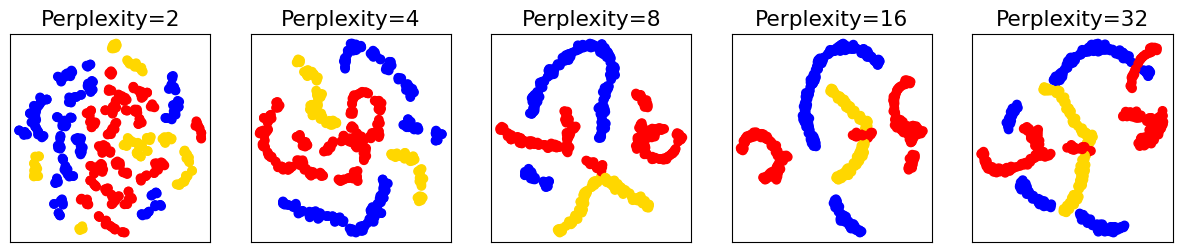

In [10]:
np.random.seed(0)
n_samples = N
n_components = 2 
perplexities = [2, 4, 8, 16, 32]
Np = len(perplexities)
mycmap = ListedColormap(["blue","red","gold" ])

(fig, subplots) = plt.subplots(1,Np , figsize=(3*Np, 2.7))

X_all = [None]
for i, perplexity in enumerate(perplexities):
    ax = subplots[i]

    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, init='random',
                         random_state=0, perplexity=perplexity)
    Y = tsne.fit_transform(data)
    t1 = time()
    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[:, 0], Y[:, 1], c=y,cmap=mycmap)
    ax.tick_params(left=False,bottom=False)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')
    X_all.append(Y)
    
plt.show()

## Different random initial states (random_state=i)

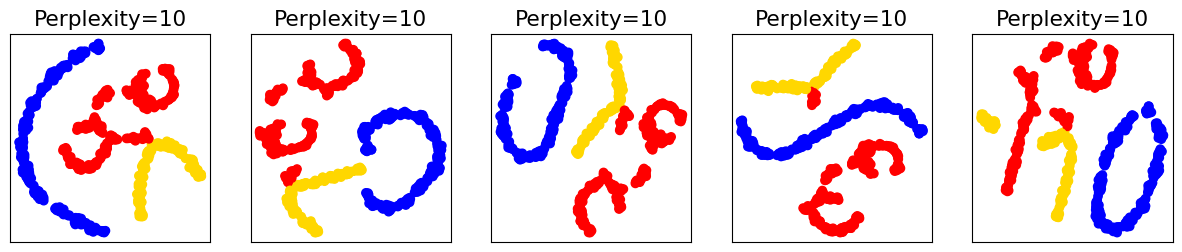

In [11]:
n_samples = N
n_components = 2 
mycmap = ListedColormap(["blue","red","gold" ])

(fig, subplots) = plt.subplots(1,Np , figsize=(3*Np, 2.7))

X_all = [None]

perplexity= 10

for i in range(5):
    np.random.seed(i) 
    ax = subplots[i]

    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, 
                         init='random',random_state=i, 
                         perplexity=perplexity)
    Y = tsne.fit_transform(data)
    t1 = time()
    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[:, 0], Y[:, 1], c=y,cmap=mycmap)
    ax.tick_params(left=False,bottom=False)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')
    X_all.append(Y)
    
plt.show()



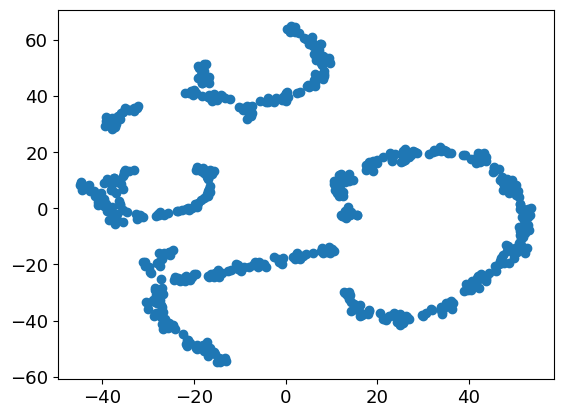

In [12]:
plt.scatter(X_all[2][:,0],X_all[2][:,1])

## 1. “eps” (ε) and “minPts” (mP) in DBSCAN algorithm for clustering

### We apply the DBSCAN clustering on the whole 12-D dataset, and visualize the results with t-SNE

[ 1  3  5  7  9 11 13 15 17 19 21 23 25 27 29]


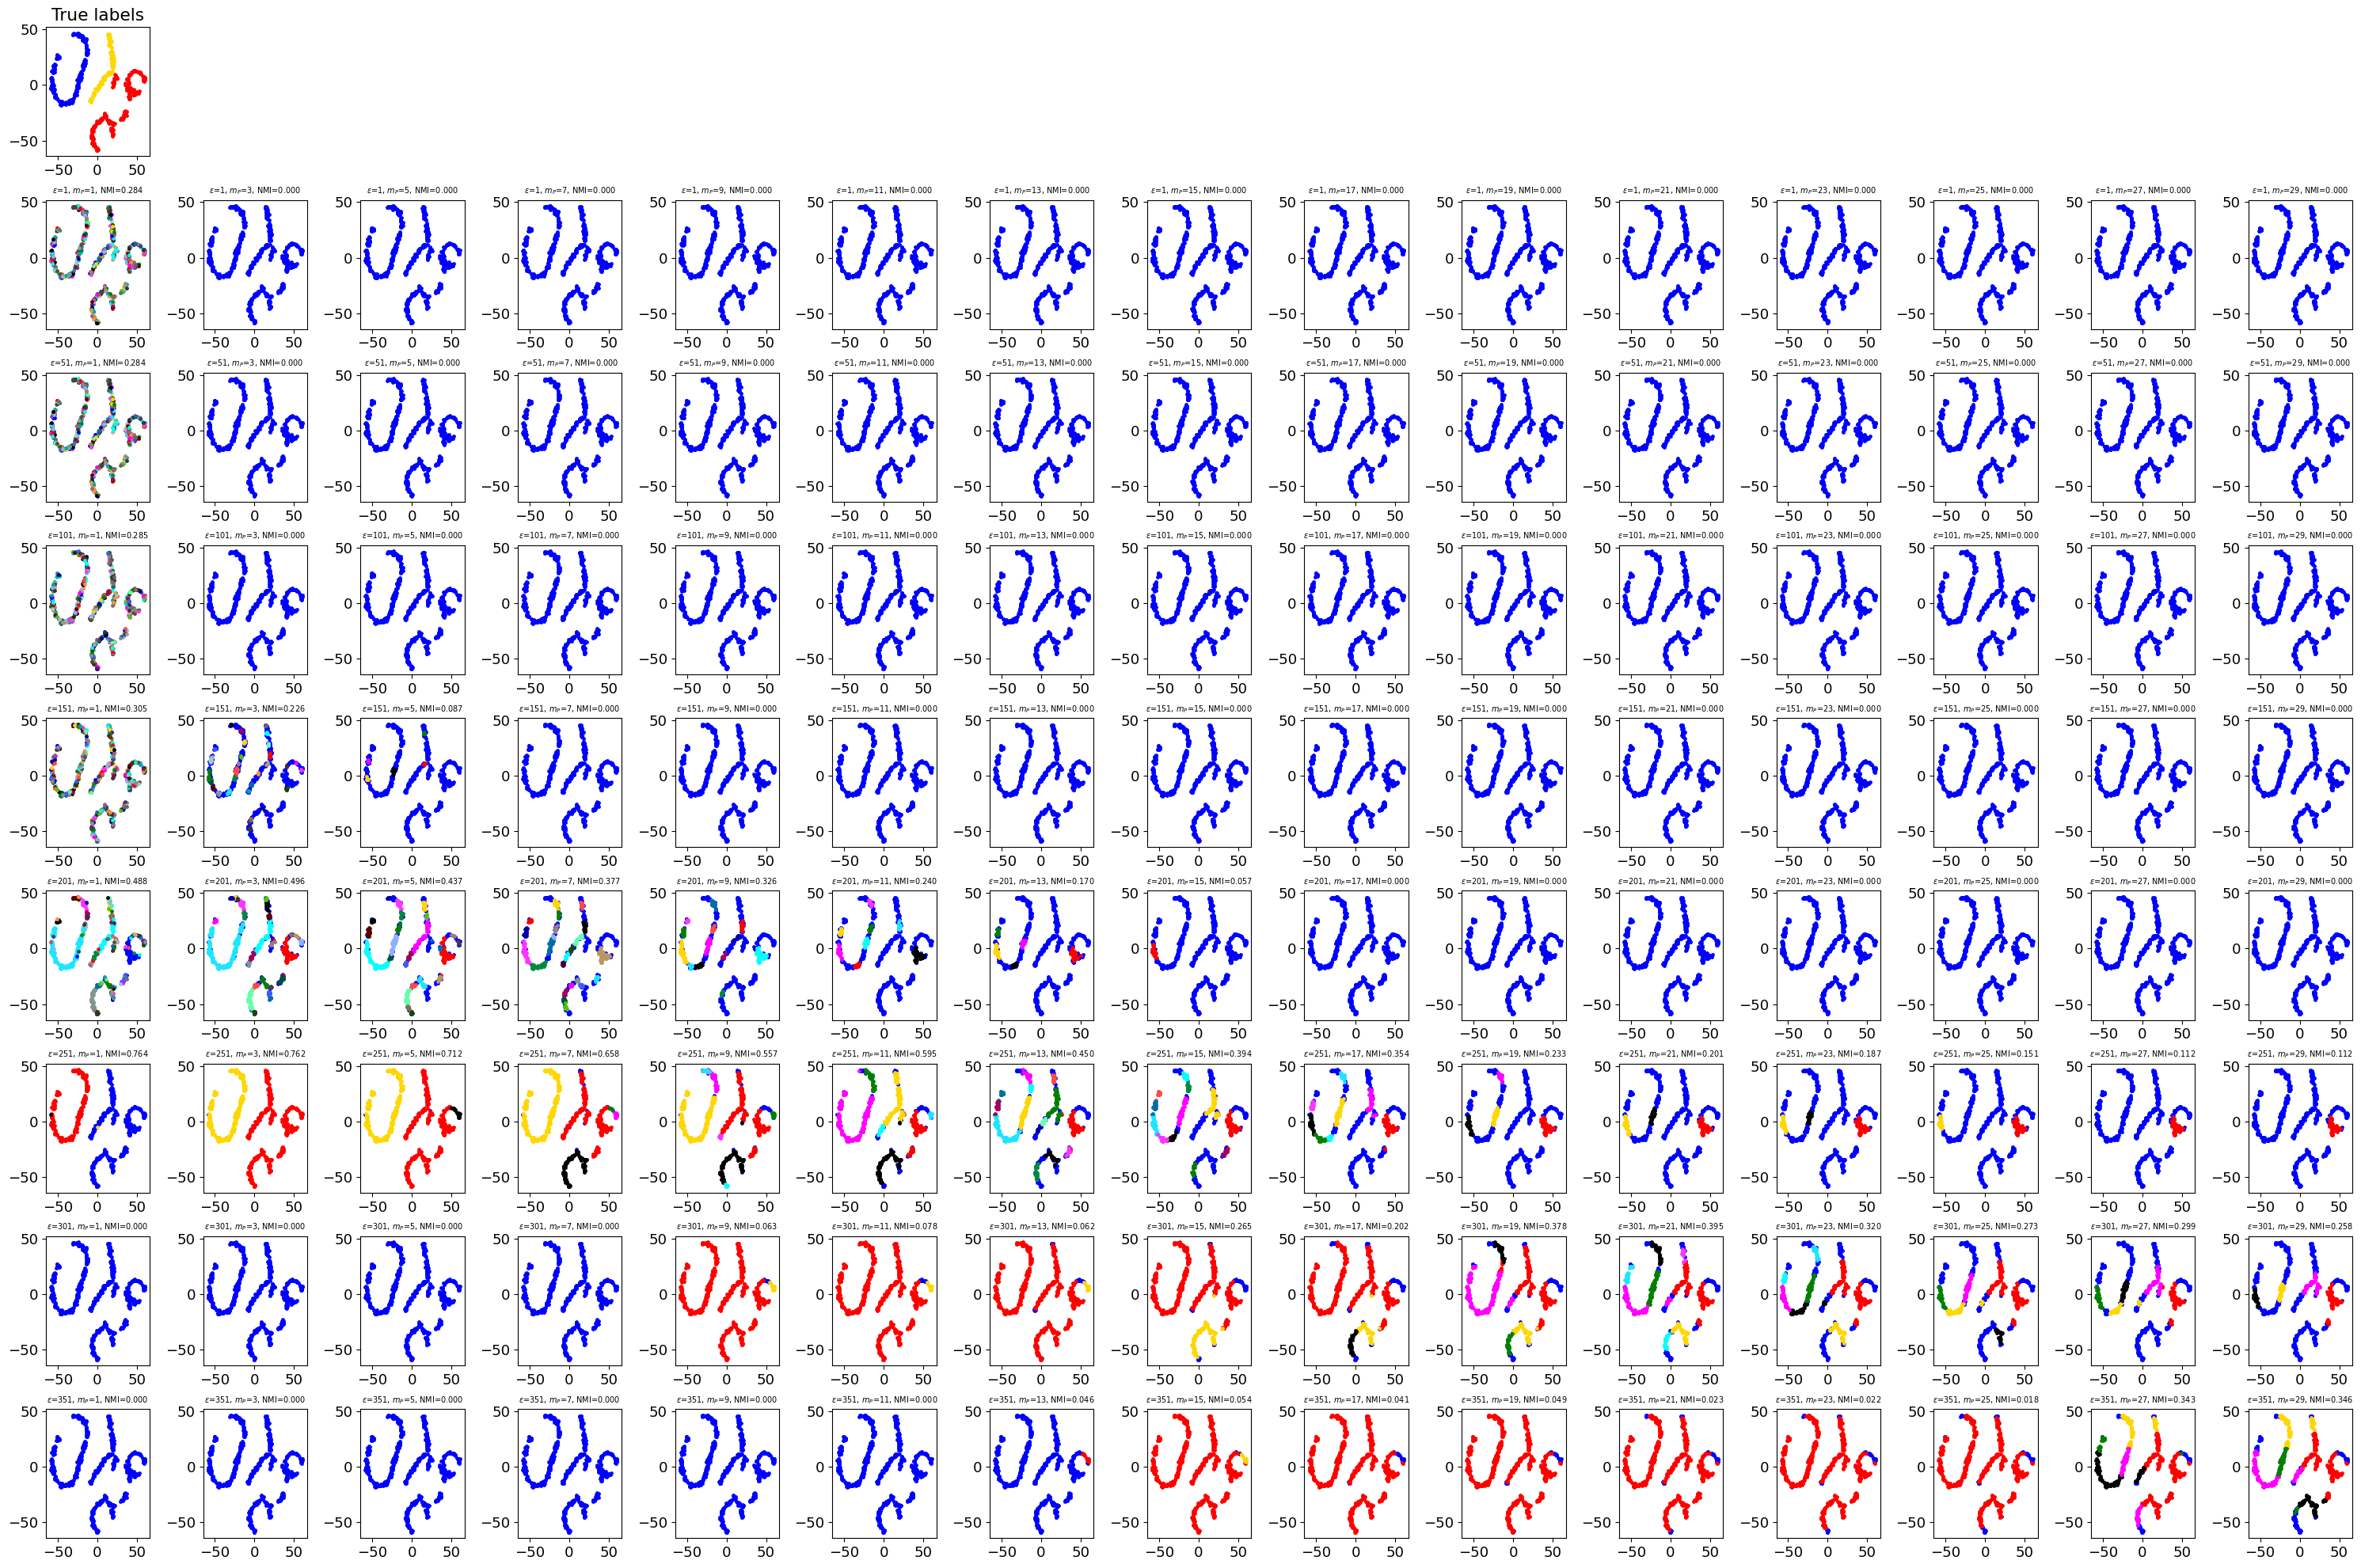

In [13]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
cpalette = ["blue","red","gold","black","magenta","green","cyan","#1CE6FF", "#FF34FF", "#FF4A46","#008941", "#006FA6", "#A30059", "#0000A6", "#63FFAC","#B79762", "#004D43", "#8FB0FF", "#997D87","#5A0007", "#809693","#1B4400", "#4FC601", "#3B5DFF", "#4A3B53","#886F4C","#34362D", "#B4A8BD", "#00A6AA", "#452C2C","#636375", "#A3C8C9", "#FF913F", "#938A81","#575329", "#00FECF", "#B05B6F"]
from collections import OrderedDict
ms = 6

def clustering(y):
    # Finds position of labels and returns a dictionary of cluster labels to data indices.
    yu = np.sort(np.unique(y))
    clustering = OrderedDict()
    for ye in yu:
        clustering[ye] = np.where(y == ye)[0]
    return clustering

def entropy(c, n_sample):
    # Measures the entropy of a cluster
    h = 0.
    for kc in c.keys():
        p=len(c[kc])/n_sample
        h+=p*np.log(p)
    h*=-1.
    return h

# Normalized mutual information function
# Note that this deals with the label permutation problem
def NMI(y_true, y_pred):
    """ Computes normalized mutual information: where y_true and y_pred are both clustering assignments
    """
    w = clustering(y_true)
    c = clustering(y_pred)
    n_sample = len(y_true)

    Iwc = 0.
    for kw in w.keys():
        for kc in c.keys():
            w_intersect_c=len(set(w[kw]).intersection(set(c[kc])))
            if w_intersect_c > 0:
                Iwc += w_intersect_c*np.log(n_sample*w_intersect_c/(len(w[kw])*len(c[kc])))
    Iwc/=n_sample
    Hc = entropy(c,n_sample)
    Hw = entropy(w,n_sample)

    return 2*Iwc/(Hc+Hw)

def plotting_ax(X, y, ax):
    # plotting function
    for i, yu in enumerate(np.unique(y)):
        pos = (y == yu)
        ax.scatter(X[pos,0], X[pos,1],c=cpalette[i%len(cpalette)],s=ms)

# DBSCAN has a few parameters, let's sweep over a few parameters and see what happens
np.random.seed(12345)
n_true_center=3
#X, ytrue = make_blobs(10000, 2, n_true_center) # Generating random gaussian mixture
X2D = X_all[3] # best(?) visualization above
X = data
y_true = y

eps_range = np.arange(1,400,50)
'''
if mean_min_dist<10:
    r=mean_min_dist
else:
    r = int(mean_min_dist)
eps_range = [r/2,r,1.5*r,2*r]
'''

min_sample_range =np.arange(1,30,2)
DIMY=len(eps_range)
DIMX=len(min_sample_range)
fig, ax = plt.subplots(DIMY+1,DIMX,figsize=(30,20))
print(min_sample_range)
i,j=0,0
nmi=1
plotting_ax(X2D,y,ax[i,j])
ax[i,j].set_title('True labels')

eps_toplot=[]
min_toplot=[]
nmi_toplot=[]
y_DBscanlabels=[]
for j in range(1,DIMX): fig.delaxes(ax[i,j])
    
for i, eps in enumerate(eps_range):
    for j, min_samples in enumerate(min_sample_range):
        model = DBSCAN(eps=eps, min_samples=min_samples)
        model.fit(X)
        y_hat = model.labels_
        plotting_ax(X2D,y_hat,ax[i+1,j])
        nmi=NMI(y_hat, y_true)
        y_DBscanlabels.append(y_hat)
        eps_toplot.append(eps)
        min_toplot.append(min_samples)
        nmi_toplot.append(nmi)
      
        ax[i+1,j].set_title(r'$\epsilon$=%.0f, $m_P$=%i, NMI=%.3f'%(eps,min_samples,nmi),fontsize=7)

plt.tight_layout(h_pad=0.5)
plt.show()


### The results aren't much satisfying along a wide spectrum of epsilon and minPTS. Below we show the normalized mutual information heat-map

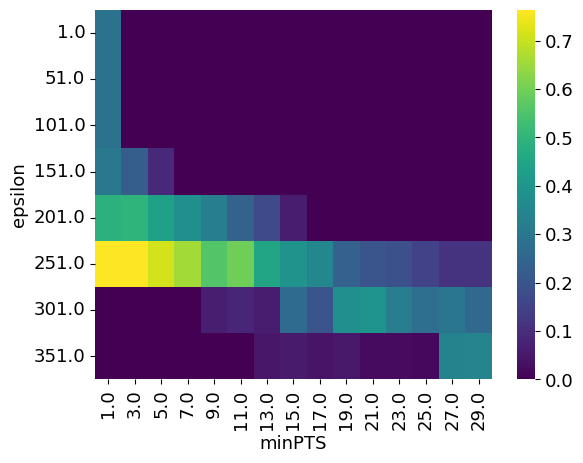

In [14]:
import seaborn as sns
import pandas as pd

z=pd.DataFrame(np.array((min_toplot,eps_toplot,nmi_toplot)).T,columns=['minPTS','epsilon','z'])
#z
df = (z.pivot(index='epsilon', columns='minPTS', values='z'))
ax = sns.heatmap(df,cmap="viridis")

#sns.heatmap(z,cmap="viridis",annot=False,vmin=np.min(nmi_toplot),vmax=np.max(nmi_toplot))

### It shows an approximately linear behaviour

### Now instead we experiment appling the DBSCAN clustering on the dataset transformed under t-SNE with perplexity=10, along a spectrum of new epsilon and minPTS parameters tailored on the transformed 2-D dataset

0.10112356 2.0970185
[ 1  3  5  7  9 11 13 15 17 19 21 23 25 27 29]


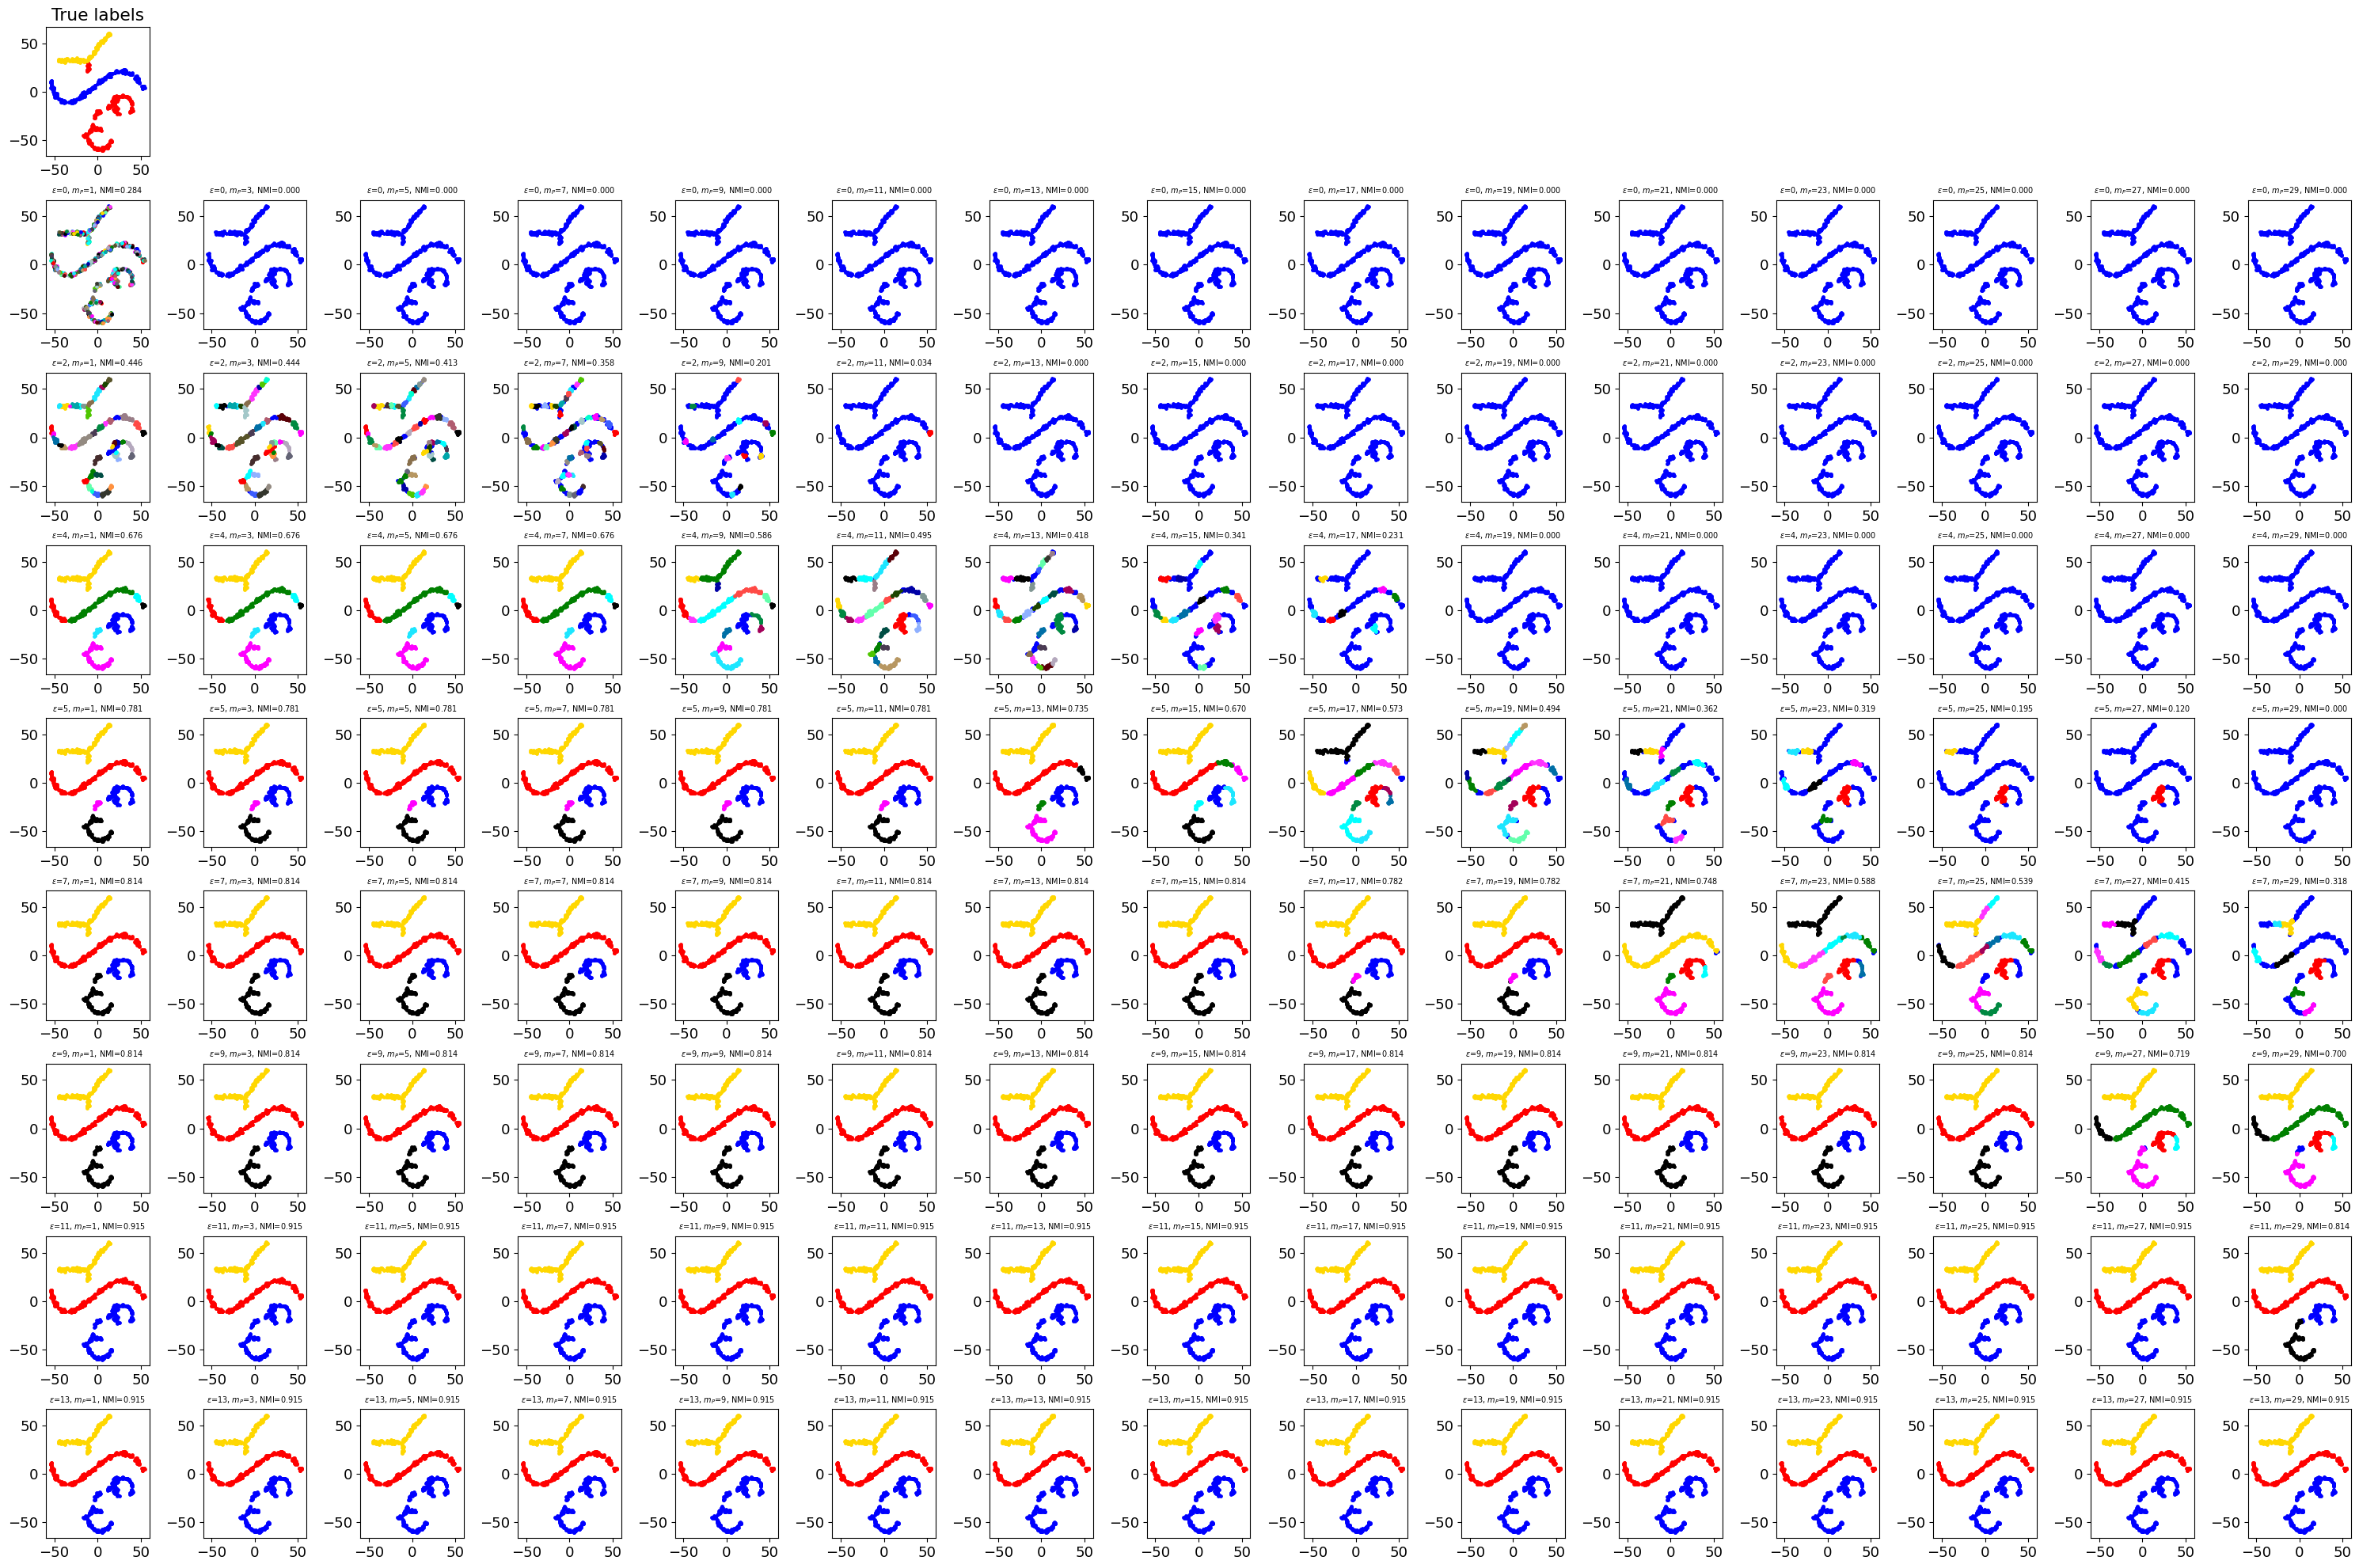

In [15]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
cpalette = ["blue","red","gold","black","magenta","green","cyan","#1CE6FF", "#FF34FF", "#FF4A46","#008941", "#006FA6", "#A30059", "#0000A6", "#63FFAC","#B79762", "#004D43", "#8FB0FF", "#997D87","#5A0007", "#809693","#1B4400", "#4FC601", "#3B5DFF", "#4A3B53","#886F4C","#34362D", "#B4A8BD", "#00A6AA", "#452C2C","#636375", "#A3C8C9", "#FF913F", "#938A81","#575329", "#00FECF", "#B05B6F"]
from collections import OrderedDict
ms = 6

def clustering(y):
    # Finds position of labels and returns a dictionary of cluster labels to data indices.
    yu = np.sort(np.unique(y))
    clustering = OrderedDict()
    for ye in yu:
        clustering[ye] = np.where(y == ye)[0]
    return clustering

def entropy(c, n_sample):
    # Measures the entropy of a cluster
    h = 0.
    for kc in c.keys():
        p=len(c[kc])/n_sample
        h+=p*np.log(p)
    h*=-1.
    return h

# Normalized mutual information function
# Note that this deals with the label permutation problem
def NMI(y_true, y_pred):
    """ Computes normalized mutual information: where y_true and y_pred are both clustering assignments
    """
    w = clustering(y_true)
    c = clustering(y_pred)
    n_sample = len(y_true)

    Iwc = 0.
    for kw in w.keys():
        for kc in c.keys():
            w_intersect_c=len(set(w[kw]).intersection(set(c[kc])))
            if w_intersect_c > 0:
                Iwc += w_intersect_c*np.log(n_sample*w_intersect_c/(len(w[kw])*len(c[kc])))
    Iwc/=n_sample
    Hc = entropy(c,n_sample)
    Hw = entropy(w,n_sample)

    return 2*Iwc/(Hc+Hw)

def plotting_ax(X, y, ax):
    # plotting function
    for i, yu in enumerate(np.unique(y)):
        pos = (y == yu)
        ax.scatter(X[pos,0], X[pos,1],c=cpalette[i%len(cpalette)],s=ms)

# DBSCAN has a few parameters, let's sweep over a few parameters and see what happens
np.random.seed(12345)
n_true_center=3
#X, ytrue = make_blobs(10000, 2, n_true_center) # Generating random gaussian mixture
X2D = X_all[4] # best(?) visualization above
X = X2D
#X_visual=x_pca[:, 1::-1] #data to visualize
X_visual=X2D
y_true = y

r_min, r_maxmin, r_max=typical_lengths(X)
print(r_min, r_maxmin)
eps_range = np.linspace(r_min, 6*r_maxmin, 8)
'''
if mean_min_dist<10:
    r=mean_min_dist
else:
    r = int(mean_min_dist)
eps_range = [r/2,r,1.5*r,2*r]
'''

min_sample_range =np.arange(1,30,2)
DIMY=len(eps_range)
DIMX=len(min_sample_range)
fig, ax = plt.subplots(DIMY+1,DIMX,figsize=(30,20))
print(min_sample_range)
i,j=0,0
nmi=1
plotting_ax(X2D,y,ax[i,j])
ax[i,j].set_title('True labels')

eps_toplot=[]
min_toplot=[]
nmi_toplot=[]
y_DBscanlabels=[]
for j in range(1,DIMX): fig.delaxes(ax[i,j])
    
for i, eps in enumerate(eps_range):
    for j, min_samples in enumerate(min_sample_range):
        model = DBSCAN(eps=eps, min_samples=min_samples)
        model.fit(X)
        y_hat = model.labels_
        plotting_ax(X_visual,y_hat,ax[i+1,j])
        nmi=NMI(y_hat, y_true)
        y_DBscanlabels.append(y_hat)
        eps_toplot.append(eps)
        min_toplot.append(min_samples)
        nmi_toplot.append(nmi)
      
        ax[i+1,j].set_title(r'$\epsilon$=%.0f, $m_P$=%i, NMI=%.3f'%(eps,min_samples,nmi),fontsize=7)

plt.tight_layout(h_pad=0.5)
plt.show()

The visualization of the results of the DBSCAN in this case is in much better agreement with the target labeling, although that's allowed by precise optimization of parameters of the t-SNE data transformation that is not obvious *a priori*, if the learning task is unsupervised

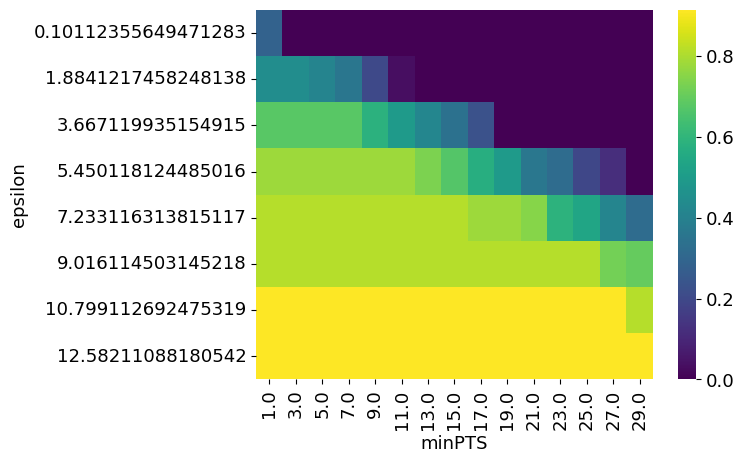

In [16]:
import seaborn as sns
import pandas as pd

z=pd.DataFrame(np.array((min_toplot,eps_toplot,nmi_toplot)).T,columns=['minPTS','epsilon','z'])
#z
df = (z.pivot(index='epsilon', columns='minPTS', values='z'))
ax = sns.heatmap(df,cmap="viridis")

#sns.heatmap(z,cmap="viridis",annot=False,vmin=np.min(nmi_toplot),vmax=np.max(nmi_toplot))

## 2. Understanding the 12-dimensional data (PCA)

### Plots of  the 3 three PCA components which describes 96% of the dataset

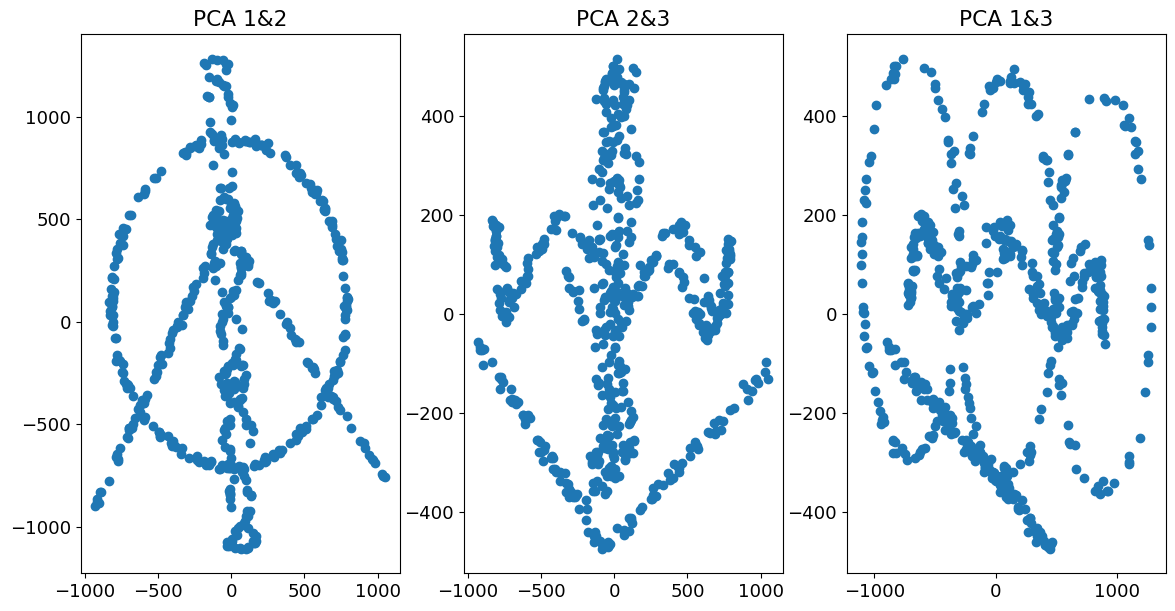

In [17]:
from sklearn.decomposition import PCA

pca= PCA(n_components=3)

z=pca.fit(x)
x_pca=pca.transform(x)

fig,ax= plt.subplots(ncols=3,nrows=1,figsize=(14,7))
ax[0].set_title("PCA 1&2")
ax[1].set_title("PCA 2&3")
ax[2].set_title("PCA 1&3")
ax[0].scatter(x_pca[:,1],x_pca[:,0])
ax[1].scatter(x_pca[:,1],x_pca[:,2])
ax[2].scatter(x_pca[:,0],x_pca[:,2])

### Plot of the 3d data set in the pca coordinate set

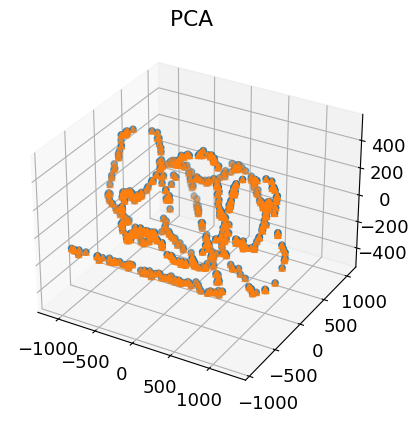

In [18]:
def randrange(n, vmin, vmax):
    """
    Helper function to make an array of random numbers having shape (n, )
    with each number distributed Uniform(vmin, vmax).
    """
    return (vmax - vmin)*np.random.rand(n) + vmin

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

n = 100

# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
for m, zlow, zhigh in [('o', -50, -25), ('^', -30, -5)]:
   
    ax.scatter(x_pca[:,0], x_pca[:,1] , x_pca[:,2], marker=m)
    ax.set_title("PCA ")

plt.show()



### Finally wee apply the DBSCAN clustering on the 3-D dataset reduced by PCA

2.1751405956922976 133.56671167114334
[ 1  3  5  7  9 11 13 15 17 19 21 23 25 27 29]


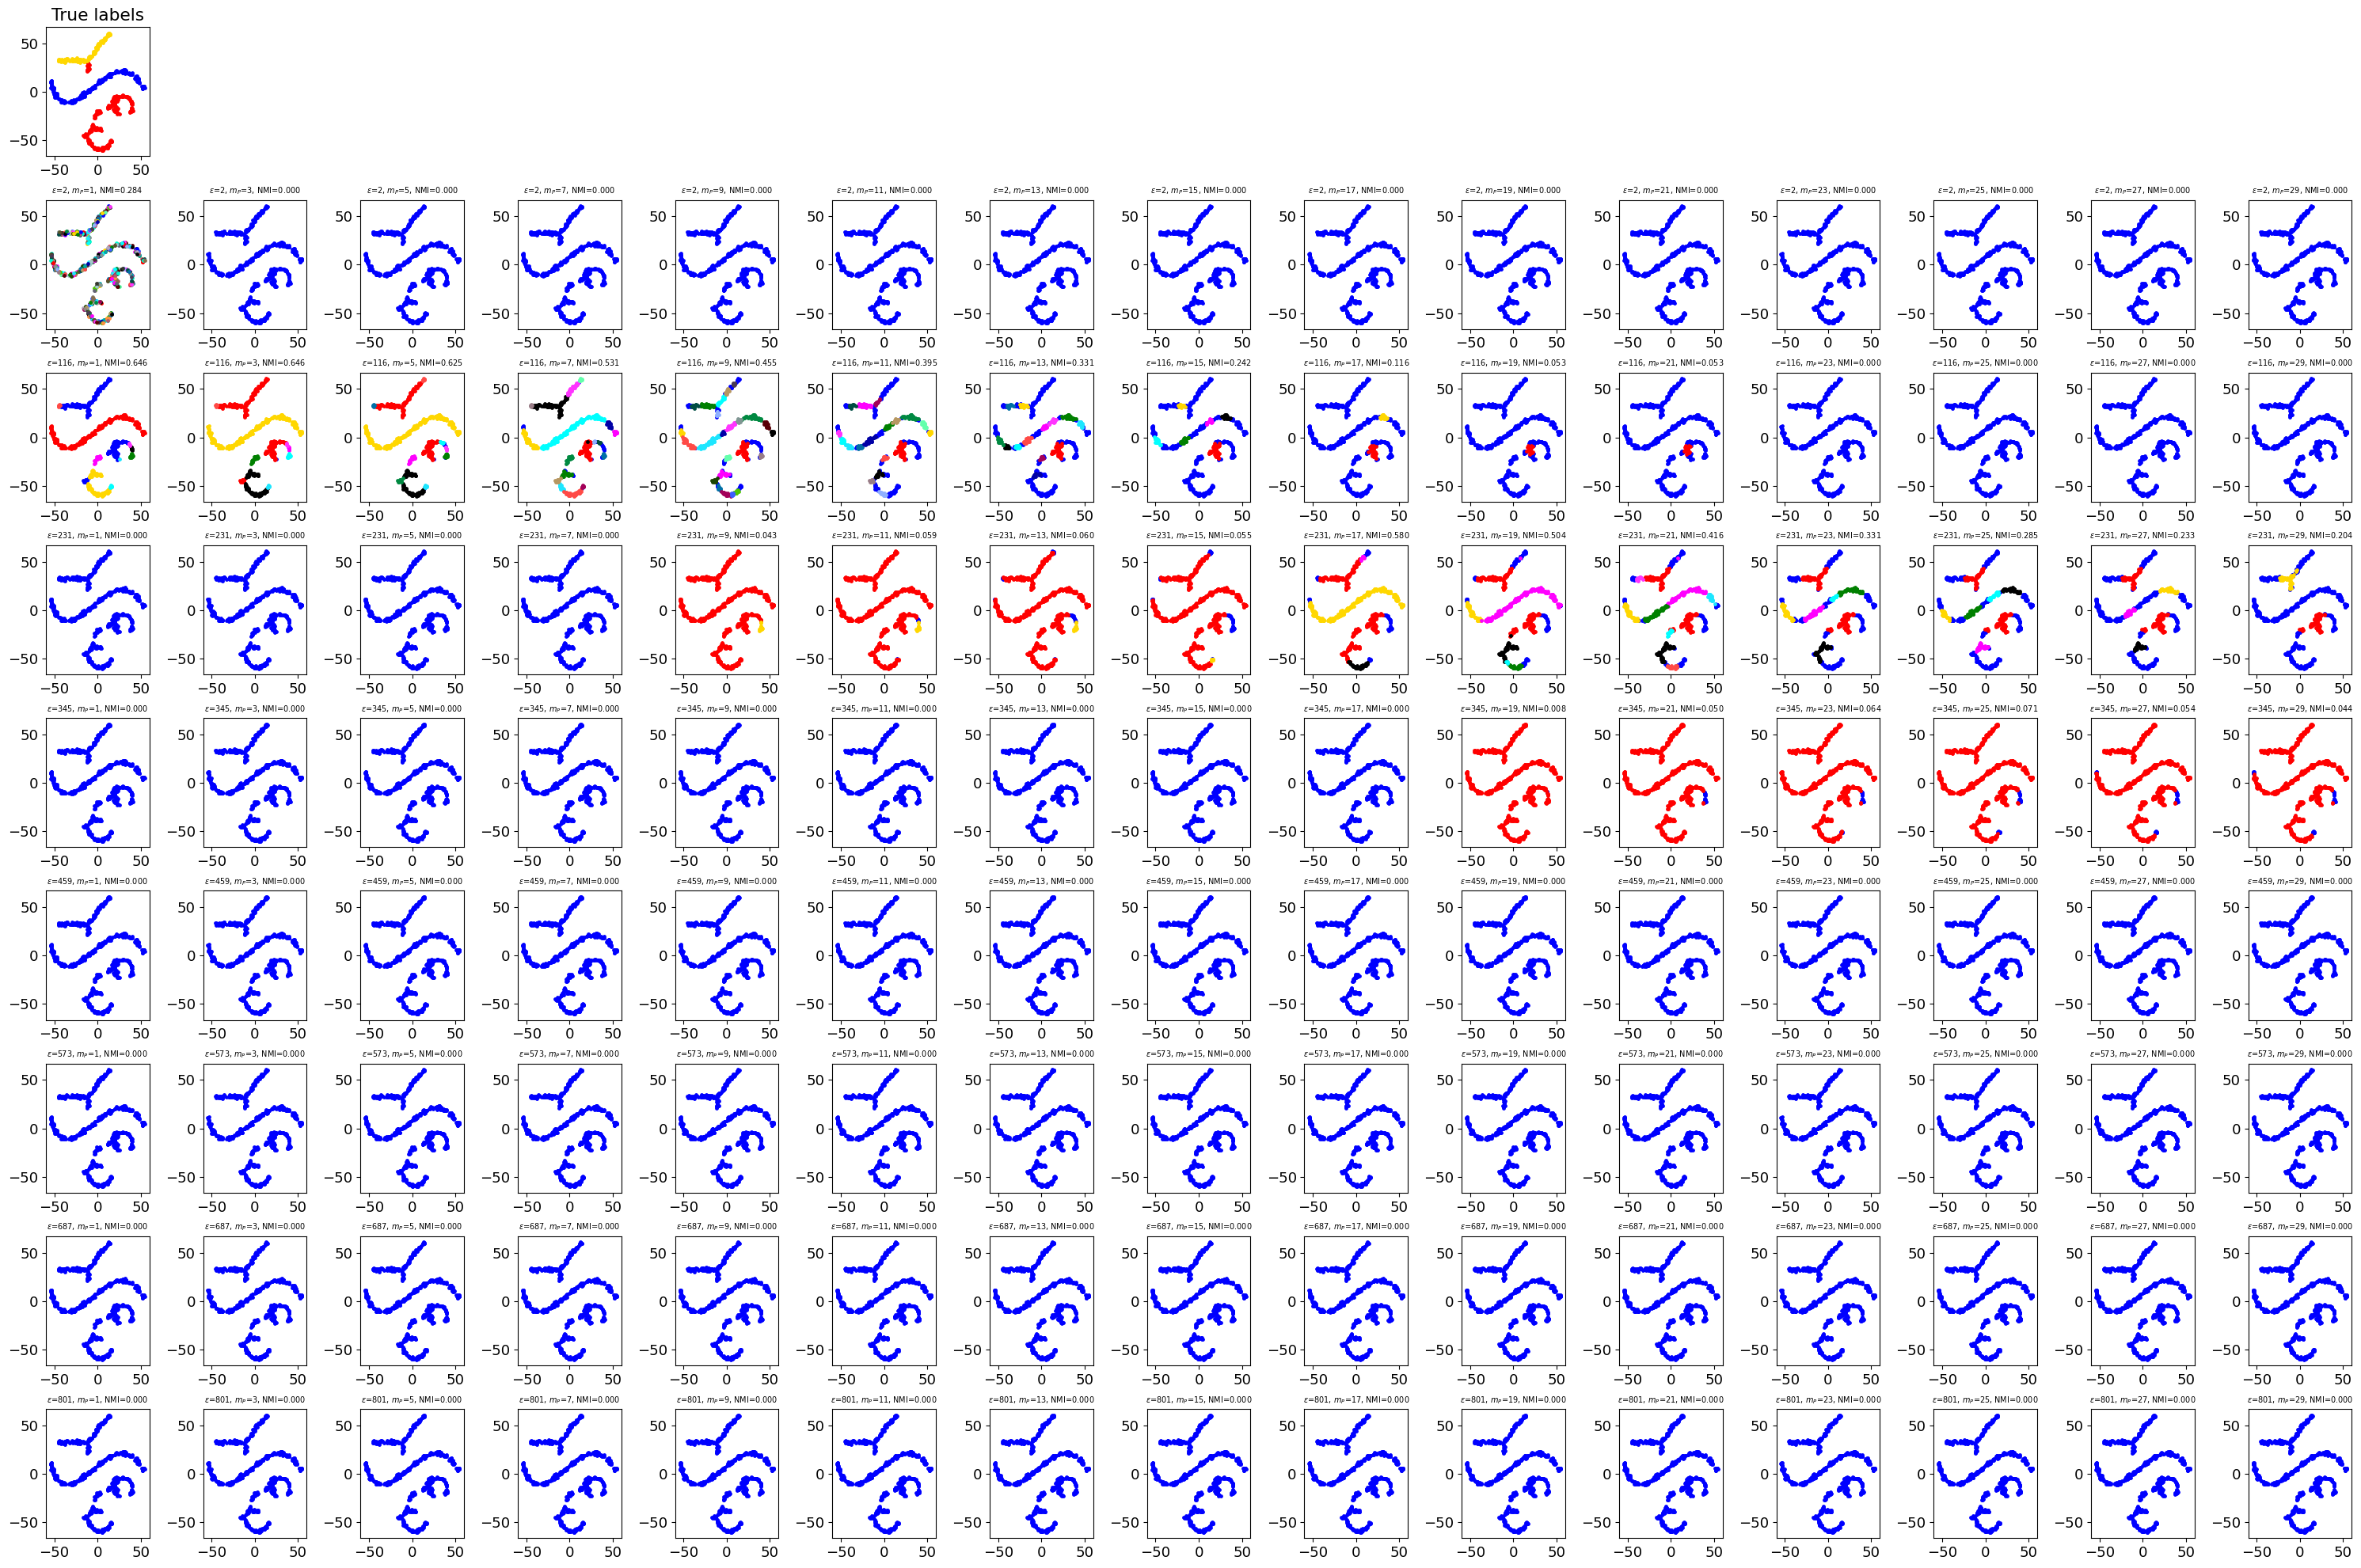

In [19]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
cpalette = ["blue","red","gold","black","magenta","green","cyan","#1CE6FF", "#FF34FF", "#FF4A46","#008941", "#006FA6", "#A30059", "#0000A6", "#63FFAC","#B79762", "#004D43", "#8FB0FF", "#997D87","#5A0007", "#809693","#1B4400", "#4FC601", "#3B5DFF", "#4A3B53","#886F4C","#34362D", "#B4A8BD", "#00A6AA", "#452C2C","#636375", "#A3C8C9", "#FF913F", "#938A81","#575329", "#00FECF", "#B05B6F"]
from collections import OrderedDict
ms = 6

def clustering(y):
    # Finds position of labels and returns a dictionary of cluster labels to data indices.
    yu = np.sort(np.unique(y))
    clustering = OrderedDict()
    for ye in yu:
        clustering[ye] = np.where(y == ye)[0]
    return clustering

def entropy(c, n_sample):
    # Measures the entropy of a cluster
    h = 0.
    for kc in c.keys():
        p=len(c[kc])/n_sample
        h+=p*np.log(p)
    h*=-1.
    return h

# Normalized mutual information function
# Note that this deals with the label permutation problem
def NMI(y_true, y_pred):
    """ Computes normalized mutual information: where y_true and y_pred are both clustering assignments
    """
    w = clustering(y_true)
    c = clustering(y_pred)
    n_sample = len(y_true)

    Iwc = 0.
    for kw in w.keys():
        for kc in c.keys():
            w_intersect_c=len(set(w[kw]).intersection(set(c[kc])))
            if w_intersect_c > 0:
                Iwc += w_intersect_c*np.log(n_sample*w_intersect_c/(len(w[kw])*len(c[kc])))
    Iwc/=n_sample
    Hc = entropy(c,n_sample)
    Hw = entropy(w,n_sample)

    return 2*Iwc/(Hc+Hw)

def plotting_ax(X, y, ax):
    # plotting function
    for i, yu in enumerate(np.unique(y)):
        pos = (y == yu)
        ax.scatter(X[pos,0], X[pos,1],c=cpalette[i%len(cpalette)],s=ms)

# DBSCAN has a few parameters, let's sweep over a few parameters and see what happens
np.random.seed(12345)
n_true_center=3
#X, ytrue = make_blobs(10000, 2, n_true_center) # Generating random gaussian mixture
X2D = X_all[4] # best(?) visualization above
X = x_pca
X_visual=x_pca[:, 1::-1] #data to visualize
y_true = y

r_min, r_maxmin, r_max=typical_lengths(X)
print(r_min, r_maxmin)
eps_range = np.linspace(r_min, 6*r_maxmin, 8)
'''
if mean_min_dist<10:
    r=mean_min_dist
else:
    r = int(mean_min_dist)
eps_range = [r/2,r,1.5*r,2*r]
'''

min_sample_range =np.arange(1,30,2)
DIMY=len(eps_range)
DIMX=len(min_sample_range)
fig, ax = plt.subplots(DIMY+1,DIMX,figsize=(30,20))
print(min_sample_range)
i,j=0,0
nmi=1
plotting_ax(X2D,y,ax[i,j])
ax[i,j].set_title('True labels')

eps_toplot=[]
min_toplot=[]
nmi_toplot=[]
y_DBscanlabels_pca=[]
for j in range(1,DIMX): fig.delaxes(ax[i,j])
    
for i, eps in enumerate(eps_range):
    for j, min_samples in enumerate(min_sample_range):
        model = DBSCAN(eps=eps, min_samples=min_samples)
        model.fit(X)
        y_hat = model.labels_
        plotting_ax(X2D,y_hat,ax[i+1,j])
        nmi=NMI(y_hat, y_true)
        y_DBscanlabels.append(y_hat)
        eps_toplot.append(eps)
        min_toplot.append(min_samples)
        nmi_toplot.append(nmi)
      
        ax[i+1,j].set_title(r'$\epsilon$=%.0f, $m_P$=%i, NMI=%.3f'%(eps,min_samples,nmi),fontsize=7)

plt.tight_layout(h_pad=0.5)
plt.show()


### The results look worse than the previous 2 cases, and the NMI heatmap looks more complex too, showing 2 local maxima.

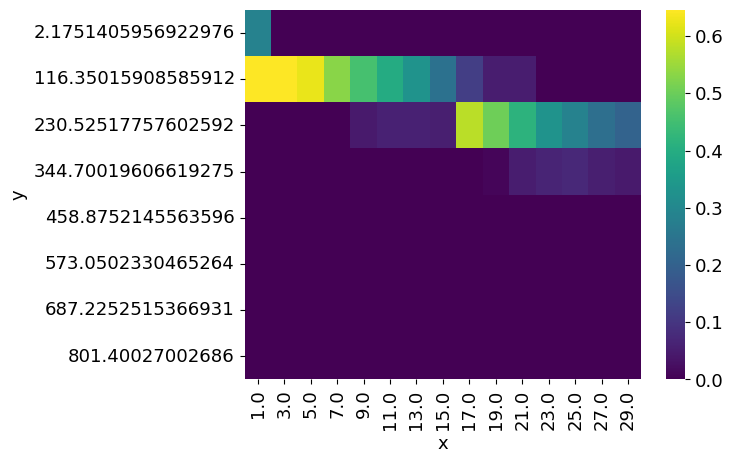

In [20]:
import seaborn as sns
import pandas as pd

z=pd.DataFrame(np.array((min_toplot,eps_toplot,nmi_toplot)).T,columns=['x','y','z'])
#z
df = (z.pivot(index='y', columns='x', values='z'))
ax = sns.heatmap(df,cmap="viridis")

#sns.heatmap(z,cmap="viridis",annot=False,vmin=np.min(nmi_toplot),vmax=np.max(nmi_toplot))

## 3. Compare different clustering methods

## a) K-means

### We apply k-means on the original dataset and show the result visualized by a transformation that maps into close 2D positions, points belonging to the same cluster.

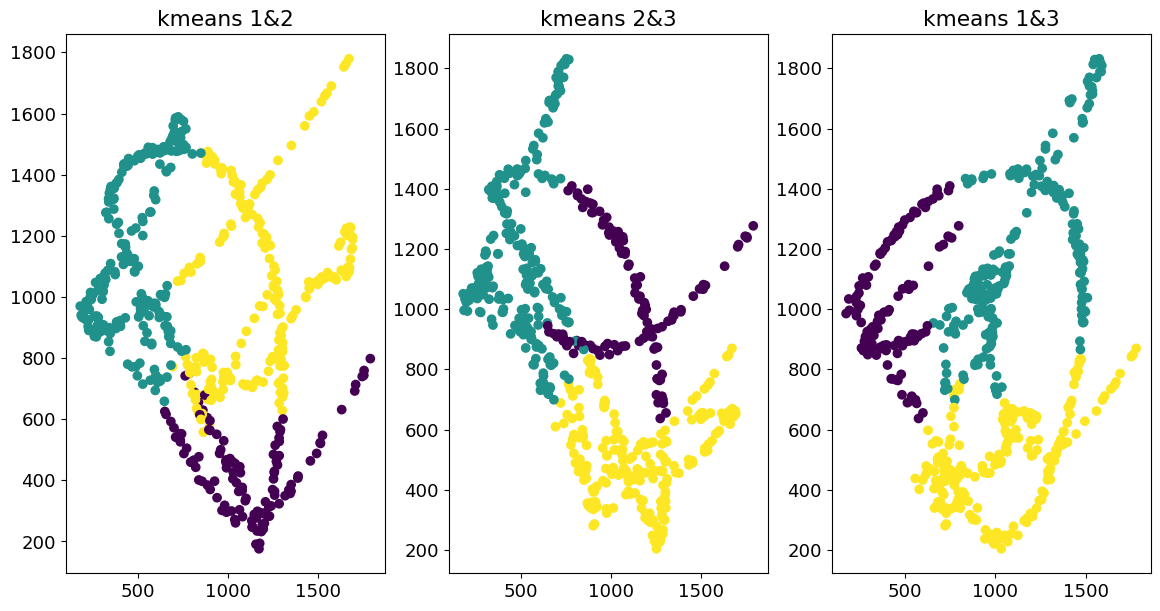

In [21]:
from sklearn.cluster import KMeans


kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(x) #create the object kmeans

x_kmeans= kmeans.fit_transform(X=x,y=None, sample_weight=None) #perform the fit and transform the dataset in a cluster distance space
centri=kmeans.fit_predict(X=x,y=None,sample_weight=None) # get the labels

#plotting
fig,ax= plt.subplots(ncols=3,nrows=1,figsize=(14,7))
ax[0].set_title("kmeans 1&2")
ax[1].set_title("kmeans 2&3")
ax[2].set_title("kmeans 1&3")


#kmeans coordinate set
ax[0].scatter(x_kmeans[:,1],x_kmeans[:,0],c=centri,cmap="viridis")
ax[1].scatter(x_kmeans[:,1],x_kmeans[:,2],c=centri,cmap="viridis")
ax[2].scatter(x_kmeans[:,0],x_kmeans[:,2],c=centri,cmap="viridis")

### The three different projections of the data-set visualized in a distance cluster space

### Now we perform k-means on the PCA data set and visualized three 2-D projections of the result.

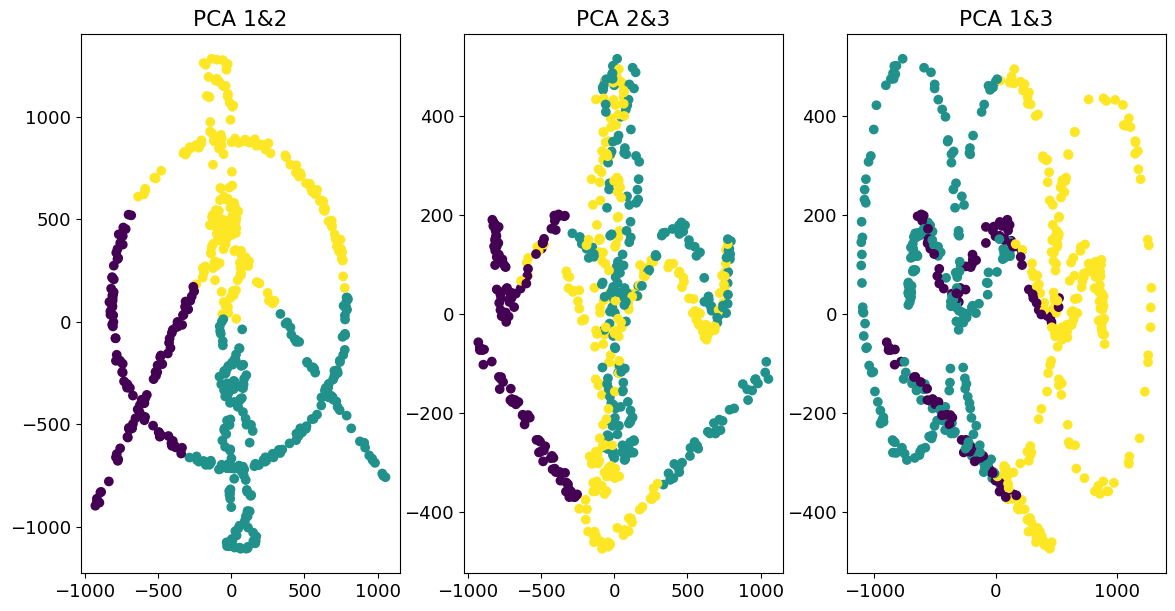

In [22]:
from sklearn.cluster import KMeans


kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(x_pca) #create the object kmeans

x_kmeans= kmeans.fit_transform(X=x_pca,y=None, sample_weight=None) #perform the fit and transform the dataset
centri=kmeans.fit_predict(X=x_pca,y=None,sample_weight=None)

fig,ax= plt.subplots(ncols=3,nrows=1,figsize=(14,7))


ax[0].set_title("PCA 1&2")
ax[1].set_title("PCA 2&3")
ax[2].set_title("PCA 1&3")
#pca coordinate set
ax[0].scatter(x_pca[:,1],x_pca[:,0],c=centri,cmap="viridis")
ax[1].scatter(x_pca[:,1],x_pca[:,2],c=centri,cmap="viridis")
ax[2].scatter(x_pca[:,0],x_pca[:,2],c=centri,cmap="viridis")

### Now we apply K-means clusterization on the dataset transformed with t-SNE

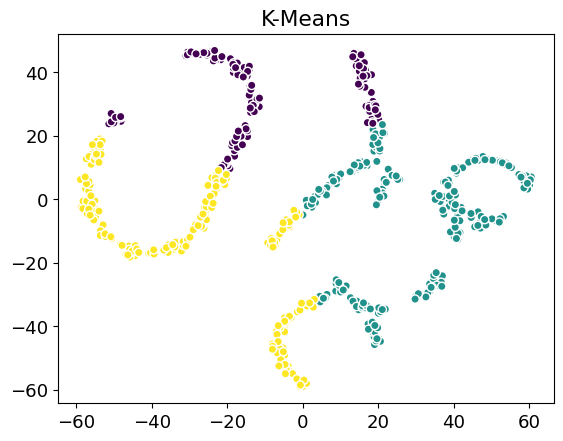

In [23]:
from sklearn.cluster import KMeans

X_kmeanstofit=X_all[3]


kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(X_kmeanstofit)

x_kmeans= kmeans.fit_transform(X=X_kmeanstofit,y=None, sample_weight=None)
centri2=kmeans.fit_predict(X=X_kmeanstofit,y=None,sample_weight=None)
#print(kmeans.cluster_centers_) #0 purple 1 green 2 yellow
plt.title("K-Means")
plt.scatter(X_kmeanstofit[:,0],X_kmeanstofit[:,1],c=centri2,cmap="viridis",edgecolors="white")

### Here there are the percentage of misclassified samples with the K-means algorithm

In [24]:
a=np.unique(centri2,return_counts=True)
b=np.unique(y,return_counts=True)
print("K-means:",a[0],a[1],"\n")
print("True Label: 1 and  2 labels are reversed with  respect to the ones of K-means","\n",b[0],b[1],"\n")

print("Percentage missclassified samples of  label", a[0][2],":",(abs(a[1][1]-b[1][2])/600)*100,"%","\n")
print("Percentage missclassified samples of label", b[0][1] ,":",(abs(a[1][2]-b[1][1])/600)*100,"%","\n")
print("Percentage of missclassified samples on the all the data set",((abs(a[1][1]-b[1][2])/600)+(abs(a[1][2]-b[1][1])/600))*100,"\n")

K-means: [0 1 2] [136 247 217] 

True Label: 1 and  2 labels are reversed with  respect to the ones of K-means 
 [0 1 2] [229 247 124] 

Percentage missclassified samples of  label 2 : 20.5 % 

Percentage missclassified samples of label 1 : 5.0 % 

Percentage of missclassified samples on the all the data set 25.5 



### Here there are the percentage of misclassified samples with the DBSCAN algorithm

In [25]:
y_best=(y_DBscanlabels[107]) #best mP and epsilon
print(len(y_DBscanlabels))
a=np.unique(y_best,return_counts=True)

print("DBSCAN:",a[0],a[1],"\n")
print("True Label: ","\n",b[0],b[1],"\n")

print("Percentage misclassified samples of  label","\n", a[0][2],(abs(a[1][1]-b[1][2])/600)*100,"%","\n")
print("Percentage misclassified samples of label", "\n",b[0][1] ,(abs(a[1][2]-b[1][1])/600)*100,"%","\n")
print("Percentage of misclassified samples on the all the data set",((abs(a[1][1]-b[1][2])/600)+(abs(a[1][2]-b[1][1])/600))*100)

240
DBSCAN: [0 1 2] [231 229 140] 

True Label:  
 [0 1 2] [229 247 124] 

Percentage misclassified samples of  label 
 2 17.5 % 

Percentage misclassified samples of label 
 1 17.833333333333336 % 

Percentage of misclassified samples on the all the data set 35.333333333333336


### As we can see the percentage of misclassified sample with the DBscan algorithm is less that the one obtained with  K-means algorithm

### K-means looks worse than DBScan for epsilon = 11 , and MinPts= 3, the comparisons have been made with the dataset obtained with the tsn algorithm, where we took the third random state and set the perplexity equal to 10.
### The DBscan works better because it's based with the density of the dataset, meanwhile the K means looks at the euclidean distance from the center.



## b) Hierarchical Clustering

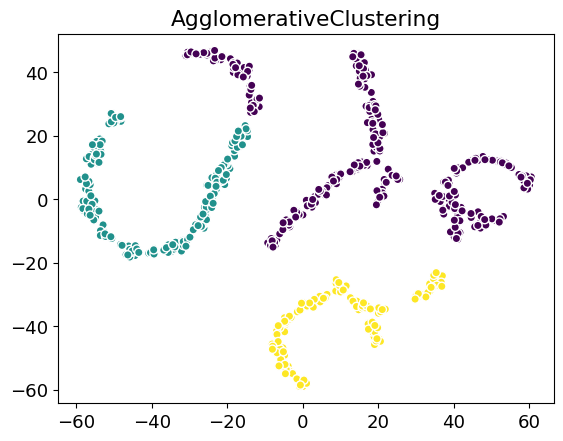

In [26]:
#define the class agglomerative clustering with euclidean mand MinPts= 3
from sklearn.cluster import AgglomerativeClustering
X_clustering=X_all[3]
agg_Clustering=AgglomerativeClustering(n_clusters=3,metric='euclidean',compute_distances=True)
model=agg_Clustering.fit(X_clustering)
agg_clust_labels=agg_Clustering.labels_

plt.title("AgglomerativeClustering")
plt.scatter(X_clustering[:,0],X_clustering[:,1],c=agg_clust_labels,cmap="viridis",edgecolors="white")

Now I compute the percentage of Missclassified samples




In [27]:
a=np.unique(agg_clust_labels,return_counts=True)

print("Agglomerative clustering:",a[0],a[1],"\n")
print("True Label: ","\n",b[0],b[1],"\n","as before label 1 and label 2 are reversed compared to the one of the Agglomerative","\n")

print("Percentage missclassified samples of  label","\n", a[0][2],(abs(a[1][1]-b[1][2])/600)*100,"%","\n")
print("Percentage missclassified samples of label", "\n",b[0][1] ,(abs(a[1][2]-b[1][1])/600)*100,"%","\n")
print("Percentage of missclassified samples on the all the data set",((abs(a[1][1]-b[1][2])/600)+(abs(a[1][2]-b[1][1])/600))*100)

Agglomerative clustering: [0 1 2] [296 174 130] 

True Label:  
 [0 1 2] [229 247 124] 
 as before label 1 and label 2 are reversed compared to the one of the Agglomerative 

Percentage missclassified samples of  label 
 2 8.333333333333332 % 

Percentage missclassified samples of label 
 1 19.5 % 

Percentage of missclassified samples on the all the data set 27.833333333333332


We see that the best algorithm is via agglomerative clustering.


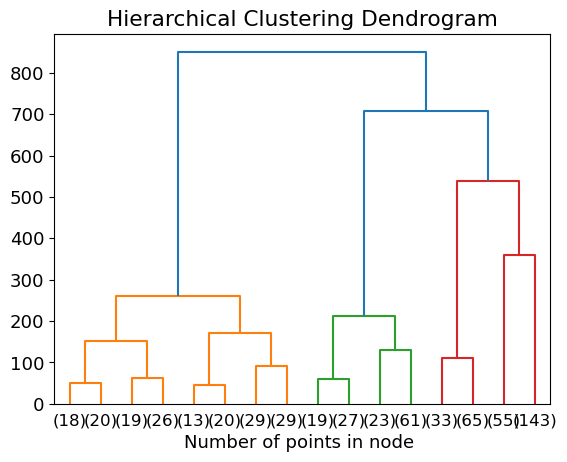

In [38]:

from scipy.cluster.hierarchy import dendrogram



def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    
    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node ")
plt.show()